# Forecasting Seizures From EEG Data

#### Author: Burak Himmetoglu

A few years back, a [Kaggle competition](https://www.kaggle.com/c/seizure-prediction) was held where contesters tried to predict onset of epileptic seizures from the EEG data collected from animal and human subjects. The competition was based on data published on several scientific journals. 

In this notebook, I will perform an exploratory analysis and provide strategies on how one can engineer features from the time-series EEG data to be used in machine learning algorithms. 

For the exploration, I will concentrate on the data from one of the dog subjects (Dog_1 in Kaggle). 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from get_prepare_data import * # Helper functions
%matplotlib inline

In [2]:
# Read data
clips_interictal, clips_preictal, clips_test = get_data(data_folder = "../data/Dog_1/")

### Interictial vs Preictal Clips

**Preictal** clips correspond to the time-series segments of the measurement before a seizure occurs (usually, segments 90 min before a seiuzure is labeled as preictal). **Interictal** clips are instead segments with no oncoming seizures.  

There are different channels where measurements are performed. In this example, there are 16 channels. In each channel, a sampling frequency determines how many data points are in 1 second (600 Hz in this example). The sampling frequency multiplied with the total measurement time per clip (~400 s in this example) determines the length of each time-series (around 240,000). Let's summarize:

$$ n_{ch} = 16 $$

$$ T = 400\, s $$

$$ f_{s} = 600\, {\rm Hz} $$

Now, let's try to see whether we can find out any clue on how the interictal and preictal clips differ by visual exploration. We first load one interictial and one preictal clip, and visualize the difference by channel.

In [3]:
# First interictial segment
clip_interictal_1 = loadmat(clips_interictal[0])
segment = list(clip_interictal_1.keys())[3] # Get segment name
data_0 = clip_interictal_1[segment][0][0][0]

# First preictal segment
clip_preictal_1 = loadmat(clips_preictal[0])
segment = list(clip_preictal_1.keys())[3] # Get segment name
data_1 = clip_preictal_1[segment][0][0][0]

Let's plot the interictial and preictal segments for all channels

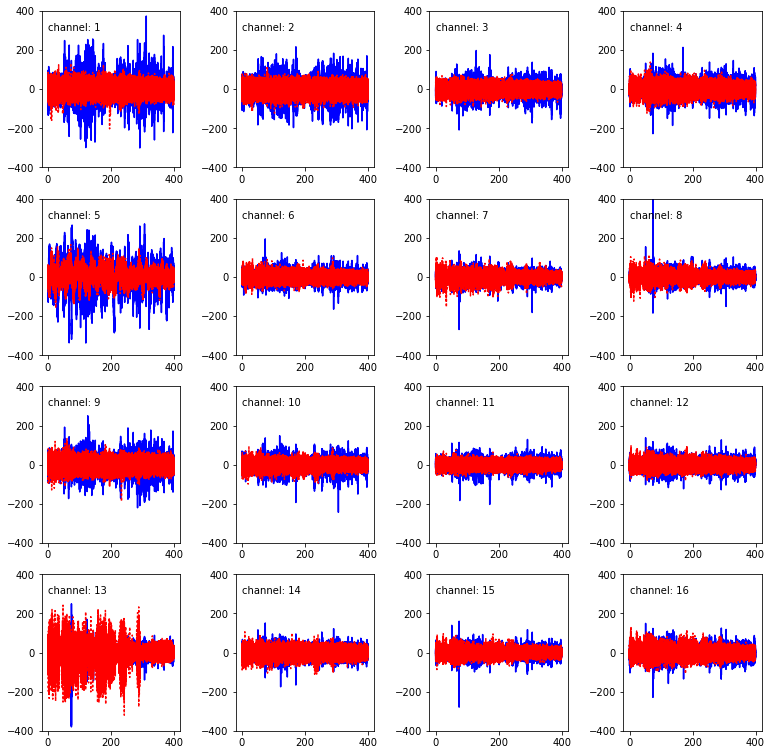

In [4]:
# Set up the figure
data_lenght_sec = np.squeeze(clip_preictal_1[segment][0][0][2]) # Total length in seconds
channels = np.squeeze(clip_preictal_1[segment][0][0][3])
fig = plt.figure(figsize = (10,10)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.4)

# Plot
x = np.linspace(0,data_lenght_sec,data_0.shape[1])
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    l1 = ax.plot(x,data_0[i], color = "blue")
    l2 = ax.plot(x,data_1[i], ls = ':', color = "red")
    ax.set_ylim([-400,400])
    txt = "channel: "+ str(i+1)
    ax.text(0,300,txt)
        

The blue lines represent an interictal segment, while the red lines are preictal. For this particular example, there seem be differences in amplitude on channels 1 and 13. For modelling, we will need to extract features from the time-series, since we cannot use the whole 240,000 data points are features (we have a much smalle number of samples than 240,000)

### Feature Engineering: Basics

Let us first consider the simplets features that one can think of: 

1. Variance within each channel 
2. Correlation between channels 

This will give us the following number of features:

$ n_{ch} $ variances

$ n_{ch} \times (n_{ch}-1)/2 $ correlations (correlation matrix is symmetric)

where $n_{ch}$ is the number of channels (16 in this example). Cycling over all the data, we can construct a design matrix $X$ which contains all the variance and correlation information for all the clips, which is what we do below:

In [5]:
# Interictial segments
X_0, Y_0 = create_basic_features(clips = clips_interictal, target = 0, n = len(channels))

# Preictal segments
X_1, Y_1 = create_basic_features(clips = clips_preictal, target = 1, n = len(channels))

The data has the following dimensions:

In [6]:
print("Interictal clips: ", X_0.shape)
print("Preictal clips: ", X_1.shape)

Interictal clips:  (480, 136)
Preictal clips:  (24, 136)


The number of preictal clips are much smaller, which means that we have to take care while training models, since there is an inbalance in the labels. We will address this later on.

Now, let us normalize the data (mean=0,std = 1) and construct principal components. We can visualize the first two principal components and observe their dependence on the target (preictal or interictial) to gain some insight.

In [7]:
from sklearn import preprocessing

# Combine the data first 
X = np.concatenate((X_0, X_1), axis = 0)
Y = np.concatenate((Y_0, Y_1), axis = 0)

# Scale
X_scl = preprocessing.scale(X)

Now, construct principal components (PC) and plot:

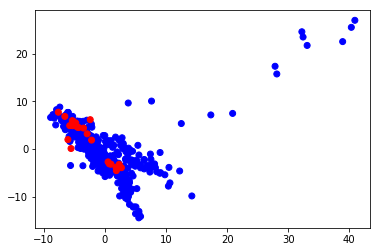

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # Get the first 2
X_pca = pca.fit_transform(X_scl) 

# Plot
color_train = []
for i in range(len(Y)):
    if (Y[i] == 0):
        color_train.append('blue')
    else:
        color_train.append('red')
        
plt.scatter(X_pca[:,0], X_pca[:,1], c = color_train)

Notice that the preictal clips (blue) correspond to PCs that span a larger range, while the interictal clips align on a line (red). This already shows some hope that one may find a separating hyperplane that could serve as a good classifier. I will not go into details of modelling here, so let's just construct a simple [Random Forest](https://en.wikipedia.org/wiki/Random_forest) model using 3-fold cross validation (CV). The hyperparameter that we will determine by CV is **max_features** which is the randomly chosen number of features used to construct each decision tree.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cls = RandomForestClassifier(n_estimators=1000)
mtry = [1,2,3,7,11,14,20,25]
grid = GridSearchCV(cls, param_grid={'max_features' : mtry},
                   scoring = 'roc_auc', cv = 3, verbose = 1,
                   n_jobs = 4)

# Fit
grid.fit(X_scl,Y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:   21.6s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_features': [1, 2, 3, 7, 11, 14, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

The performance metric we use in this case is the area under the ROC curve ([AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)). The CV chooses the best model with the highest AUC, which is:

In [13]:
# Best model
print("Best mtry = {:d}".format(grid.best_params_['max_features']))
print("Best AUC = {:4f}".format(grid.best_score_))

Best mtry = 1
Best AUC = 0.778646


This is not a great AUC value, but we can definitely do much better with more carefully chosen features. 

Now that we have a simple solution to the problem, we can improve by engineering better features.

### Spectral Power based features (PIB: Power in band)

For this approach, I will follow the [article](https://doi.org/10.1371/journal.pone.0081920) by Howbert et al., which studies forecasting of seizures in dogs. 

Let's look at some of the features we can obtain using the frequency space of the time series. We will construct spectral power in 6 frequency bands. Power will be computed from the Fourier Transform of 1 min blocks of each segment. This increases the number of data instance per segment, which is also useful for reducing the variance of the models we train.

Now, recall that the segment is 400s long, and the sampling frequency is 600 Hz. This means that if we have 60 sec bloks, we will obtain 400//60 = 6 data instances. Schematically, this looks like:

![title](img/eeg.001.png)

The power spectrum (i.e. absolute value of the Fourier transform in this particular case) will be computed in the following frequency bands:

[0.1,4], [4,8], [8,12], [12,30], [30,70], [70,180] Hz

i.e. 6 bands. Computing power in each band for each channels(16 of them) yields 6x16=96 features for a single block. Thus, from a single segment, we obtain the following contribution to the design matrix:

$$ X \in {\mathbb R}^{n_{blocks} \times n_{bands}\cdot n_{ch}} = {\mathbb R}^{6\times 96} $$ 

with the targets 

$Y = {\rm ones}(6)$ for preictal, and $Y = {\rm zeros}(6)$ for interictial.

As an example, let us look at one preictal, one ineterictial segment

In [14]:
# Limits of frequency bands
freq_bands = np.array([0.1, 4, 8, 12, 30, 70, 180])

# Sampling frequency
sampling_freq = np.squeeze(clip_preictal_1[segment][0][0][1])

X_0, Y_0 = create_PIB_features(data_0, 0, freq_bands, sampling_freq, block_s = 60)
X_1, Y_1 = create_PIB_features(data_1, 1, freq_bands, sampling_freq, block_s = 60)

Let's visualize the data

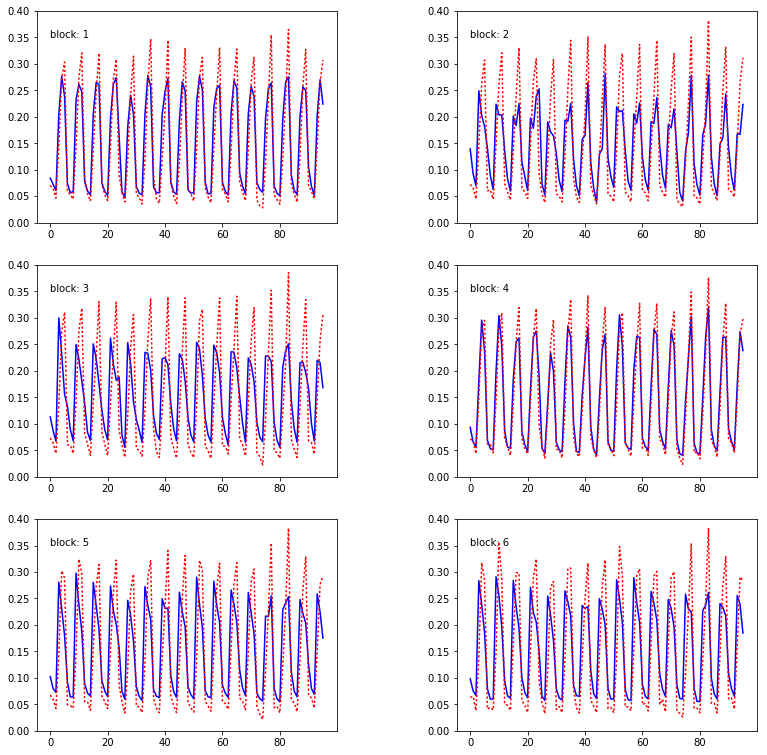

In [15]:
# Set up the figure
data_instances, data_length = X_0.shape
fig = plt.figure(figsize = (10,10)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.4)

# Plot
x = np.arange(data_length)
for i in range(data_instances):
    ax = fig.add_subplot(3, 2, i + 1)
    l1 = ax.plot(x,X_0[i], color = "blue")
    l2 = ax.plot(x,X_1[i], ls = ':', color = "red")
    ax.set_ylim([0,0.4])
    txt = "block: "+ str(i+1)
    ax.text(0,0.35,txt)

As can be seen, the spectral features provide a nice distinction between preictal and interictial segments. The preictal blocks have larger power in all the 16 channels.

### Collecting all the data

Now, given that we have 6 blocks per segment, our design matrix will have 6 times more data instances! Let's collect all the data:


In [16]:
X_1, Y_1 = PIB(clips_preictal, 1, freq_bands, block_s = 60, n_channels = 16)
X_0, Y_0 = PIB(clips_interictal, 0, freq_bands, block_s = 60, n_channels = 16)

In [17]:
print("New size for preictal data: ", X_1.shape)
print("New size for interictal data: ", X_0.shape)

New size for preictal data:  (144, 96)
New size for interictal data:  (2880, 96)


Now we can use these to construct a better model. Let's try a simple Random Forest again:

In [18]:
# Combine the data first 
X = np.concatenate((X_0, X_1), axis = 0)
Y = np.concatenate((Y_0, Y_1), axis = 0)
Y = np.squeeze(Y) # (N,1) to (N,)

# Scale
X_scl = preprocessing.scale(X)

# Construct the classifier and perform search (5-folds)
cls = RandomForestClassifier(n_estimators=1000)
mtry = [1,2,3,7,11,14,20,25]
grid = GridSearchCV(cls, param_grid={'max_features' : mtry},
                   scoring = 'roc_auc', cv = 3, verbose = 1,
                   n_jobs = 4)

# Fit
grid.fit(X_scl,Y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:  2.3min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_features': [1, 2, 3, 7, 11, 14, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [19]:
# Best model
print("Best mtry = {:d}".format(grid.best_params_['max_features']))
print("Best AUC = {:4f}".format(grid.best_score_))

Best mtry = 25
Best AUC = 0.607451


Worse AUC!! This could be related to the fact that we have a smaller number of features in this case, and we have not included inter-channel and inter-band correlations. We only kept the power within a single band. The next step would be to construct more features.